In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import	cross_val_score

In [3]:
data_set = pd.read_csv('Data4645251.csv')
train = data_set.iloc[0:5000,]
test = data_set.iloc[5000:,]

# PART A.
### Q1\)

Considering only $Y$ and $X_{1}$ - $X_{6}$, there are two arguments in favour of the K-nearest neighbours: 
1. the response variable y was sampled from the logistic function applied to a function $f(X)$ which is cubic in $X_{1}$, discontinuous in $X_{2}$ and linear in $X_{3}$. The true decision boundary is therefore non-linear. In this case we would expect KNN to outperfrom LASSO LR provided that an optimal number of neighbours is correctly determined by cross validation. Nevertheless, in Elements of Statistical Learning (Chapter 4), Hastie & Tibshirani show that even in the case of a non-linear decision boundary favourable to KNN, a poorly chosen K can yield terrible results compared to other classification methods;
2. KNN performs best when $n>>p$, where n is the number of observations in our training set and p the number of predictors. This is because a low-bias/high-variance method such as KNN - when $K >> 1$ - requires a lot of training data in order for it to "see" most of the true variance in that data and thus win at the bias-variance tradeoff. This is also explained by the curse of dimensionality, whereby parametric methods (such as logistic regression) will tend to outperform non-parametric approaches (such as KNN) when there is a small number of observations per predictor (Hastie & Tibshirani).

Considering these two arguments, here we are only looking at 6 predictors with a training set size of n=5000, so we expect KNN to outperform LASSO LR provided a K parameter properly estimated with cross-validation.

### Q2\)

This time considering $X_{1}$ - $X_{203}$, with $n=5000$ and $p=203$ we can no longer confidently say that $n>>p$. Following our reasoning above, $n=5000$ is no longer enough training data to cover enough of the variance of a function that has its signal jammed by 200 noisy and irrelevant predictors, so the high variance that KNN naturally has with K large enough is no longer offset by a reduction in variance like it was the case previously. However, because the true decision boundary is still non-linear, it is uncertain whether LASSO logistic regression can lead to a lower prediction error than KNN even in this case.

### Q3)
### a)

In [4]:
train_6X = train.drop(columns=[x for x in train.columns[1:] if int(x.split('X')[1]) > 6])
test_6X = test.drop(columns=[x for x in test.columns[1:] if int(x.split('X')[1]) > 6])
X_train, y_train = train_6X.drop(columns=['Y']), train_6X['Y']
X_test, y_test = test_6X.drop(columns=['Y']), test_6X['Y']

The $X$ predictors are all on very similar scales, so we do not need to worry about that biasing KNN.

In [ ]:
y_train.value_counts()

Y
1    2692
0    2308
Name: count, dtype: int64

In [6]:
K_vector = np.arange(1, 200, 1)
df_scores = pd.DataFrame(columns=['k', 'mean', 'stdev'])

for k in K_vector:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10)
    df_scores = pd.concat([df_scores, pd.DataFrame({'k': [k], 'mean': [scores.mean()], 'stdev': [scores.std(ddof=1)]})])


C:\Users\Gaspard\AppData\Local\Temp\ipykernel_19900\3069478100.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_scores = pd.concat([df_scores, pd.DataFrame({'k': [k], 'mean': [scores.mean()], 'stdev': [scores.std(ddof=1)]})])


[]

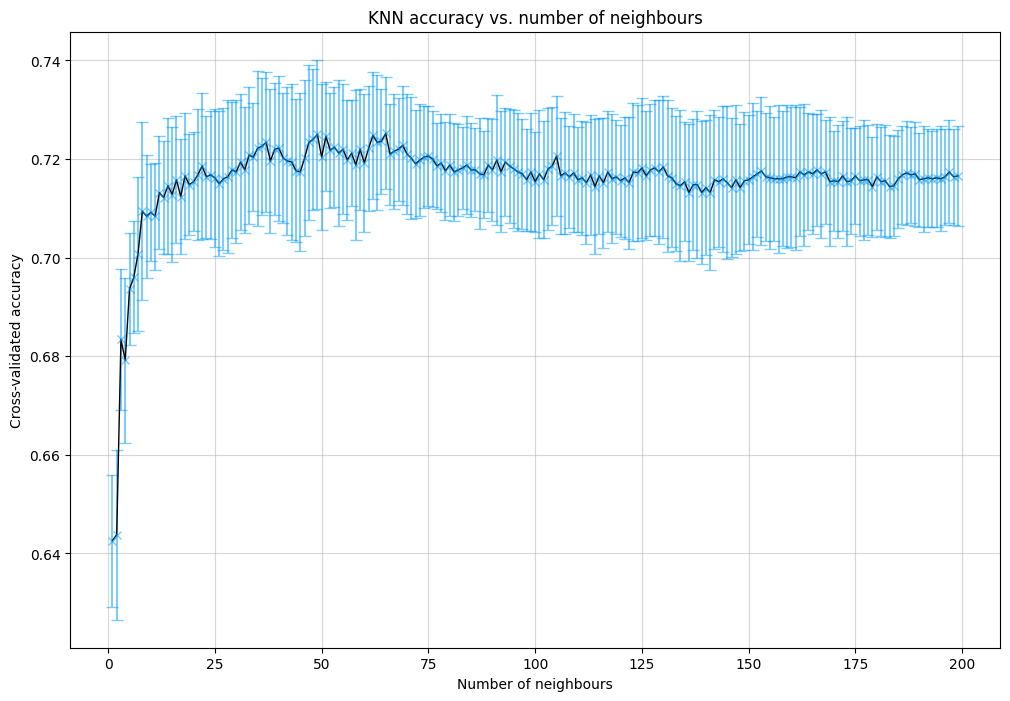

In [10]:
plt.figure(figsize=(12, 8))
plt.errorbar(df_scores['k'], df_scores['mean'], yerr=df_scores['stdev']
             , fmt='x', color='#0099f8', ecolor='#0099f8', capsize=4, alpha=0.5)
plt.plot(df_scores['k'], df_scores['mean'], color='black', linewidth=1)
plt.xlabel('Number of neighbours')
plt.ylabel('Cross-validated accuracy')
plt.title('KNN accuracy vs. number of neighbours')
plt.grid(True, alpha=0.5)
plt.plot()

Let us now have a closer look at the k with the maximum mean and where our preferred k stands:

[]

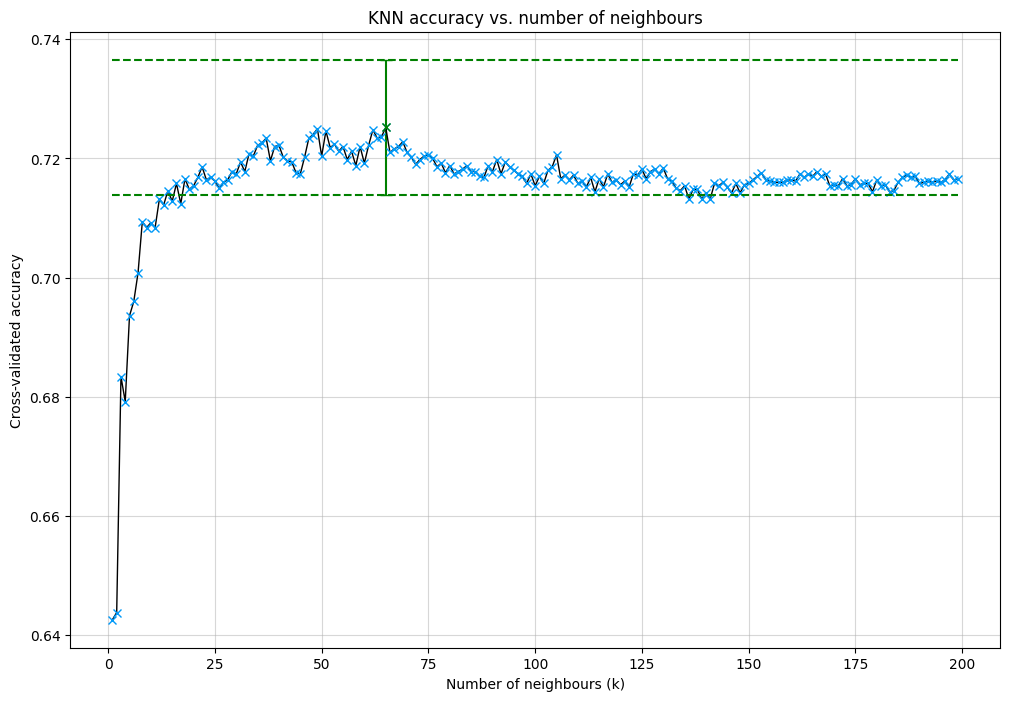

In [9]:
max_row = df_scores.iloc[np.argmax(df_scores['mean'])]
upper_bound = [max_row['mean'] + max_row[['stdev']]] * len(K_vector)
lower_bound = [max_row['mean'] - max_row[['stdev']]] * len(K_vector)

plt.figure(figsize=(12, 8))
plt.errorbar(max_row['k'], max_row['mean'], yerr=max_row['stdev']
             , fmt='x', color="green", ecolor="green", capsize=4)
plt.plot(df_scores['k'], df_scores['mean'], color='black', marker='x', mec='#0099f8', linewidth=1)
plt.plot(df_scores['k'], upper_bound, linestyle='--', color='green')
plt.plot(df_scores['k'], lower_bound, linestyle='--', color='green')
plt.xlabel('Number of neighbours (k)')
plt.ylabel('Cross-validated accuracy')
plt.title('KNN accuracy vs. number of neighbours')
plt.grid(True, alpha=0.5)
plt.plot()

In [ ]:
max_row['k']

65

$K=65$ yielded the highest average accuracy during cross-validation. Accuracy drops below one standard deviation of $accuracy_{K=65}$ for the first time for $K=136$. Afterwards, accuracy plateaus until the largest tested K: as K grows and the decision boundary of KNN becomes more linear, KNN maintains roughly the same accuracy. Following the best practices advised by Robert Tibshirani, we should pick the simplest model - or the model with the lowest possible variance - within one standard deviation of the mean of the highest performing configuration of our KNN model, which is $K=65$ here: this approach helps reduce variance while maintaining an accuracy score very close to that of the optimal $K$. Since the accuracy for $K=200$ is still within range, we could pick that value, but just because a higher $K$ maintains good accuracy does not mean we are safe from underfitting (after all, we are trying to find balance between bias and variance), therefore as an arbitrary rule we will select the last $K$ before accuracy first drops below the range, which is $K=135$. Now that we have successfully "regularised" our KNN model, we are going run it with both $K=65$ and $K=135$ on the holdout set to compare the test errors. Since the $K=65$ model is more flexible, we should expect higher variance on unseen data.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=65).fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('KNN, K=65 accuracy: ', round(accuracy_score(y_pred=y_pred, y_true=y_test), 3))

KNN, K=65 accuracy:  0.718


As expected, our test set accuracy is slightly lower than the CV accuracy obtained before.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=135).fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('KNN, K=135 accuracy: ', round(accuracy_score(y_pred=y_pred, y_true=y_test), 3))

KNN, K=135 accuracy:  0.716


The difference in test accuracies is very minimal, therefore with the aim of finding balance between bias and variance, we will select $K=135$ as the optimal number of neighbours.

### b)

In [11]:
# code from the ESL book to generate a series of lambda parameters for CV:
lam_max = np.abs(X_train.T @ (y_train - y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1), np.log(1e-4), 50))

In [12]:
logit = LogisticRegressionCV(
    Cs=1/lam_val
    , cv=10
).fit(X_train, y_train)

y_pred = logit.predict(X_test)
accuracy = round(accuracy_score(y_pred=y_pred, y_true=y_test), 3)
accuracy

0.668

In [ ]:
print('best lambda: ', round(logit.C_[0], 3))

best lambda:  0.041


### c)

With an optimal shrinkage lambda of $\sim0.04$, LASSO logistic regression achieved a lower accuracy (0.668) than KNN with $K=135$ (0.716) on the holdout set: these results match our expectations from Q1\). Provided an optimal K number of neighbours, KNN was set to outperform LASSO LR because the true decision boundary is non-linear, and we consider that the $n>>p$ condition is satisfied in this case.

### Q4)
### a)

In [13]:
X_train, y_train = train.drop(columns=['Y']), train['Y']
X_test, y_test = test.drop(columns=['Y']), test['Y']

In [21]:
K_vector = np.arange(70, 401, 1)
df_scores = pd.DataFrame(columns=['k', 'mean', 'stdev'])

for k in K_vector:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10)
    df_scores = pd.concat([df_scores, pd.DataFrame({'k': [k], 'mean': [scores.mean()], 'stdev': [scores.std(ddof=1)]})])

C:\Users\Gaspard\AppData\Local\Temp\ipykernel_19900\1436045880.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_scores = pd.concat([df_scores, pd.DataFrame({'k': [k], 'mean': [scores.mean()], 'stdev': [scores.std(ddof=1)]})])


[]

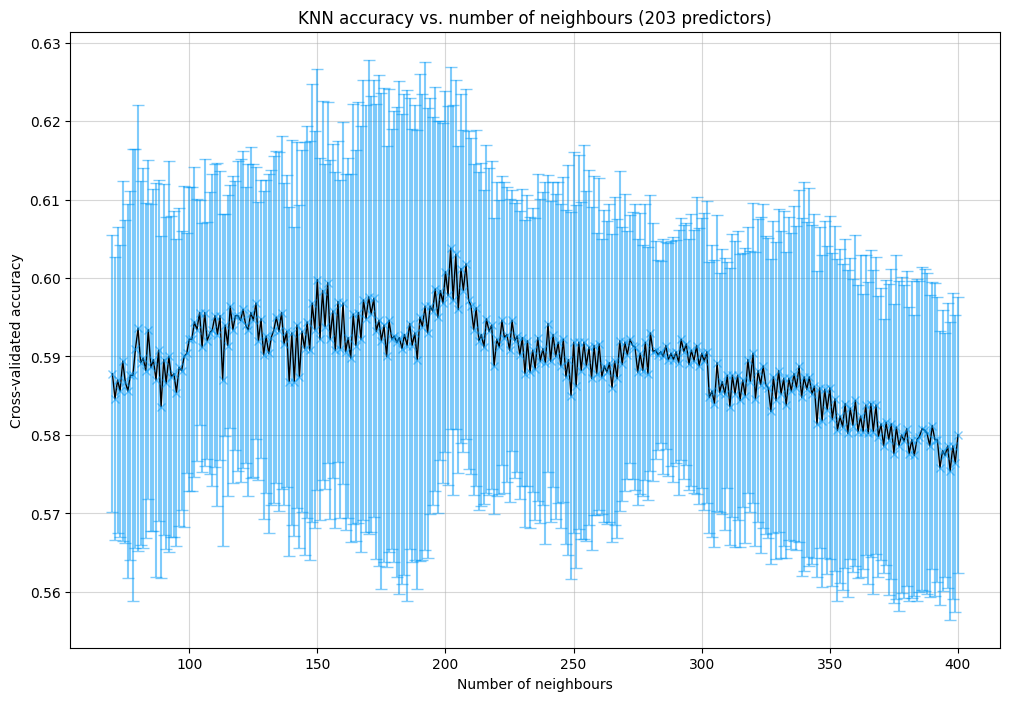

In [22]:
plt.figure(figsize=(12, 8))
plt.errorbar(df_scores['k'], df_scores['mean'], yerr=df_scores['stdev']
             , fmt='x', color='#0099f8', ecolor='#0099f8', capsize=4, alpha=0.5)
plt.plot(df_scores['k'], df_scores['mean'], color='black', linewidth=1)
plt.xlabel('Number of neighbours')
plt.ylabel('Cross-validated accuracy')
plt.title('KNN accuracy vs. number of neighbours (203 predictors)')
plt.grid(True, alpha=0.5)
plt.plot()

[]

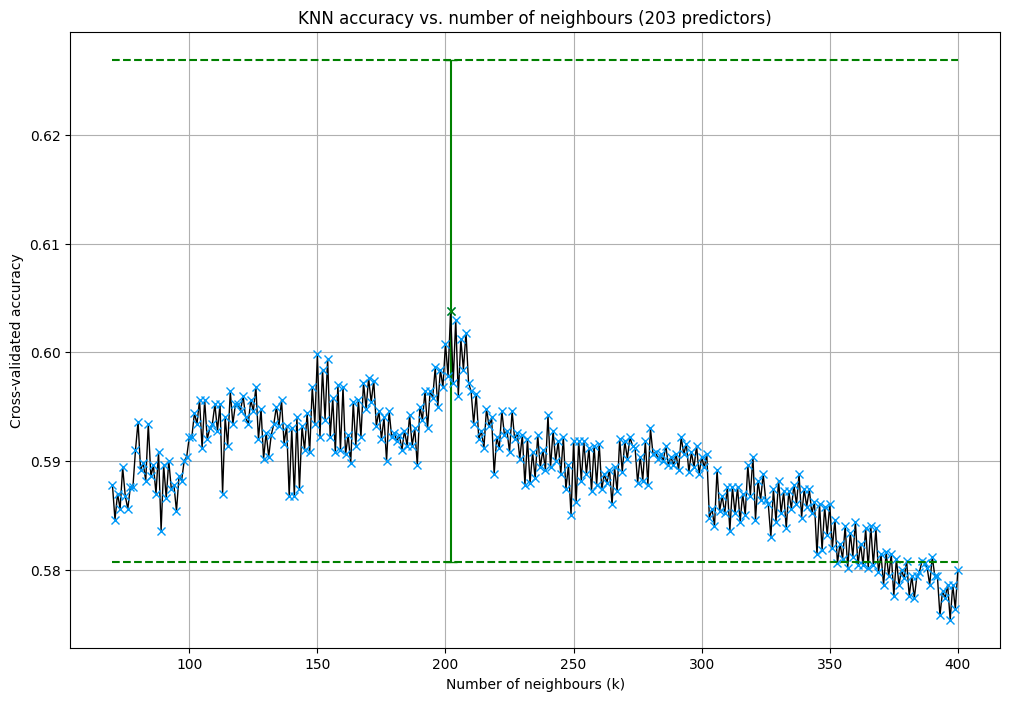

In [23]:
max_row = df_scores.iloc[np.argmax(df_scores['mean'])]
upper_bound = [max_row['mean'] + max_row[['stdev']]] * len(K_vector)
lower_bound = [max_row['mean'] - max_row[['stdev']]] * len(K_vector)

plt.figure(figsize=(12, 8))
plt.errorbar(max_row['k'], max_row['mean'], yerr=max_row['stdev']
             , fmt='x', color="green", ecolor="green", capsize=4)
plt.plot(df_scores['k'], df_scores['mean'], color='black', marker='x', mec='#0099f8', linewidth=1)
plt.plot(df_scores['k'], upper_bound, linestyle='--', color='green')
plt.plot(df_scores['k'], lower_bound, linestyle='--', color='green')
plt.xlabel('Number of neighbours (k)')
plt.ylabel('Cross-validated accuracy')
plt.title('KNN accuracy vs. number of neighbours (203 predictors)')
plt.grid(True)
plt.plot()

In [24]:
max_row['k']

202

The highest training accuracy is achieved with 202 neighbours. This number is almost three times the optimal K with 6 predictors: because we are dealing with a 203-dimensional space this time, each individual observation has many less nearby neighbours, which may explain why the optimal accuracy is reached with a higher K. We also see that the accuracy starts dropping below one standard deviation of the optimal K around $K=350$.

In [25]:
knn = KNeighborsClassifier(n_neighbors=202).fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('KNN, K=202 accuracy: ', round(accuracy_score(y_pred=y_pred, y_true=y_test), 3))

KNN, K=202 accuracy:  0.599


In [30]:
knn = KNeighborsClassifier(n_neighbors=352).fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('KNN, K=350 accuracy: ', round(accuracy_score(y_pred=y_pred, y_true=y_test), 3))

KNN, K=350 accuracy:  0.581


### b)

In [28]:
# code from the ESL book to generate a series of lambda parameters for CV:
lam_max = np.abs(X_train.T @ (y_train - y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1), np.log(1e-4), 50))

logit = LogisticRegressionCV(
    Cs=1/lam_val
    , cv=10
).fit(X_train, y_train)

y_pred = logit.predict(X_test)
accuracy = round(accuracy_score(y_pred=y_pred, y_true=y_test), 3)
accuracy

0.65

In [29]:
print('best lambda: ', round(logit.C_[0], 3))

best lambda:  0.009


### c)

With an optimal shrinkage lambda of $\sim0.009$, LASSO logistic regression achieved a higher accuracy (0.65) than KNN with $K=350$ (0.581) on the holdout set: again, these results match our expectations from Q2\): LASSO LR was set to outperform KNN because the $n>>p$ condition cannot be considered satisfied anymore here. This lack of training data relative to the number of predictors has two implications: 
- the model does not get to capture the true variance in the data accurately enough,
- the curse of dimensionality has a strong negative impact on the performance of KNN, particularly in this case with 203 predictors. Our data takes its values in a 203-dimensional space which is very sparsely populated with 'only' 5000 observations, compared to a much smaller 6-dimensional space populated with the same number of obervations like in Q3): because it is so sparsely populated, there are not enough nearby neighbours to properly model the true underlying function of the data $f(X)$ (Hastie & Tibshirani).

# PART B.

### Q1)
Our goal is to predict the severity of depressive symptoms after 12 months using the characteristics that were assessed at the start of the study. 
- Our interest here is mainly in predicting our response variable and less in the causal effect of some of the predictors on the response. We are less interested in the exact form of $\hat{f}(X)$, rather, we want to maximise the prediction accuracy.
- Since we are prioritising prediction over interpretability and inference, we will lean more towards non-linear models.
- Our training set contains 1000 observations which is a fairly big sample size for a statistical study. We also consider that $n=1000 >> p=20$.

Our training set being relatively large has two implications:
- we can use a low-bias method without worrying about variance too much, since our model will "see" most of the variance in the data with 1000 observations
- ridge regression will probably do well in our context, and since our interest is in predicting we do not necessarily need to shrink some coefficients down to exactly zero, so there is no clear case for LASSO here.

For the second model, we choose a non-linear method: while GAM sounded like a good fit, I unfortunately ran into complications with the pygam library and had to fall back on polynomial regression. The latter is a low-bias method which we also expect to perform well for the reasons outlined above.

### Q2)

In [119]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
import warnings
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [18]:
data = pd.read_csv('MHpredict.csv')
for col in data:
    if data[col].dtype not in ['int64', 'float64']:
        print(f'{col}: {data[col].unique()}')

disType: ['anxiety disorder' 'comorbid disorder' 'depressive disorder']
Sexe: ['male' 'female']
pedigree: ['Yes' 'No']
alcohol: ['No positive alcohol diagnose'
 'Diagnose alcohol dependent or alcohol abuse']
bTypeDep: ['No depressive disorder' 'Recurrent MDD' 'First onset MDD' 'Dysthymia']
bSocPhob: ['Positive' 'Negative']
bGAD: ['Positive' 'Negative']
bPanic: ['Negative' 'Positive']
bAgo: ['Negative' 'Positive']
RemDis: [ True False]
sample: ['Specialised mental health care' 'Primary care' 'General population']
ADuse: [False  True]
PsychTreat: [ True False]


We first convert our categorical variables into factor:

In [24]:
bool_cols = data.select_dtypes(include='bool').columns
data[bool_cols] = data[bool_cols].astype(int)
cat_cols = data.select_dtypes(include='O').columns.tolist()
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

In [33]:
X = data.drop(columns=['dep_sev_fu'])
y = data['dep_sev_fu']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=4645251)
print(f'Training set size: {len(y_train)}')
print(f'Test set size: {len(y_test)}')

Training set size: 1000
Test set size: 500


### Ridge regression

Text(0, 0.5, 'Cross-validated MSE')

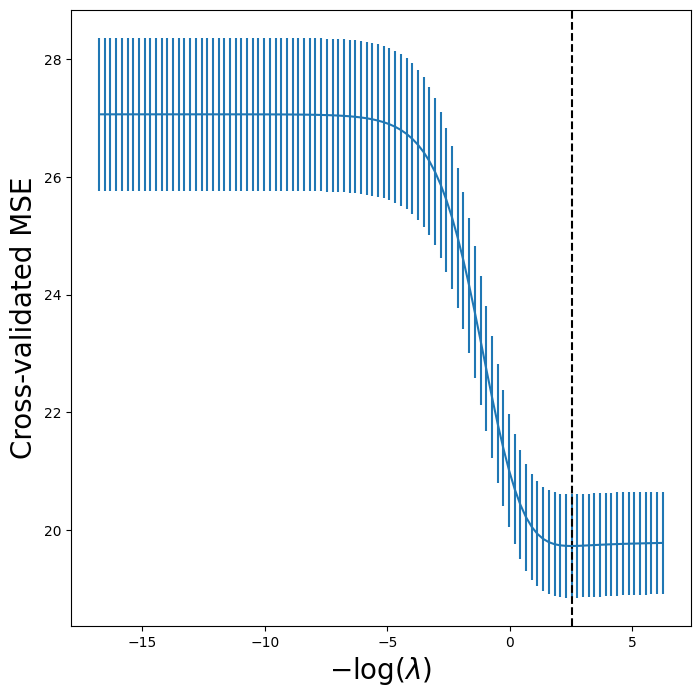

In [121]:
# code from Elements of Statistical Learning, chapter 6 lab
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=SyntaxWarning)

kfold = 10
lambdas = 10**np.linspace(8, -2, 100) / y_train.std()
scaler = StandardScaler(with_mean=True, with_std=True)
ridgeCV = ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])
pipeCV.fit(X_train, y_train)

tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(
    -np.log(lambdas)
    , tuned_ridge.mse_path_.mean(1)
    , yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(kfold)
)
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

In [50]:
best_lambda = tuned_ridge.alpha_
print('best lambda:', '{:.3e}'.format(best_lambda))
print('CV MSE with best lambda:', '{:.3e}'.format(np.min(tuned_ridge.mse_path_.mean(1)), 3))

best lambda: 7.947e-02
CV MSE with best lambda: 1.973e+01


This chart was obtained following the instructions in the chapter 6 lab of Elements of Statistical Learning. The optimal $-\log(\lambda)$ appears as the x-value of the vertical black dashed line, and corresponds to an optimal $\lambda$ of $7.947e-02$. The optimal average MSE for that lambda is $19.73$.

In [116]:
# test:
y_pred = pipeCV.predict(X_test)
ridge_test_mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
print('Ridge test MSE:', '{:.3e}'.format(ridge_test_mse))

Ridge test MSE: 1.977e+01


After running our optimal Ridge model on the holdout set, we get a slightly higher test MSE of $19.77$.

### Polynomial regression

We can only apply a polynomial effect on our continous predictors, so we  must first visualise their independent relationship with our response variable ```dep_sev_fu```:

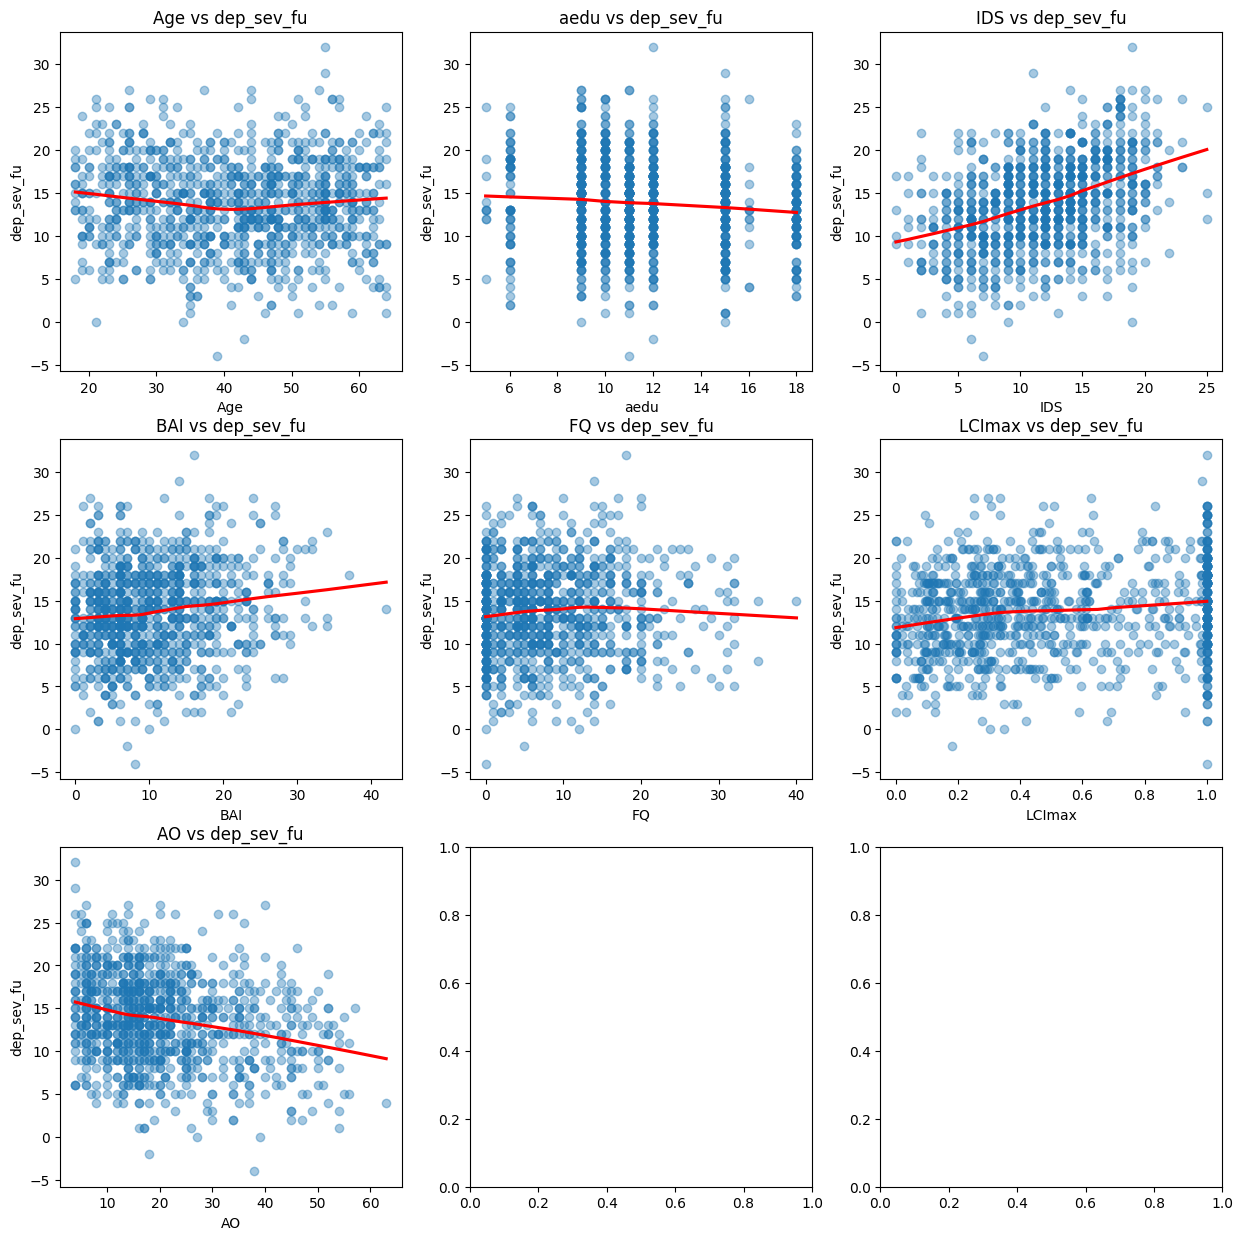

In [ ]:
continuous_cols = ['Age', 'aedu', 'IDS', 'BAI', 'FQ', 'LCImax', 'AO']

fig, axes = subplots(3, 3, figsize=(15, 5 * 3))
axes = axes.flatten()
for i, col in enumerate(continuous_cols):
    ax = axes[i]
    sns.regplot(x=X_train[col], y=y_train, lowess=True, ax=ax, scatter_kws={'alpha': 0.4}, line_kws={'color': 'red'})
    ax.set_xlabel(col)
    ax.set_ylabel('dep_sev_fu')
    ax.set_title(f'{col} vs dep_sev_fu')
plt.show()

The predictors that stand out as having a potential polynomial relationship with ```dep_sev_fu``` are ```Age```, ```FQ```and ```LCImax```. The rest of the continuous predictors seem to have a linear relationship with the response. Therefore we apply a polynomial effect of degree 2 to each of those three and then fit a linear regression with the rest of the predictors unchanged:

In [118]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_cols = ['Age', 'FQ', 'LCImax']
X_train_poly = X_train.copy().drop(columns=poly_cols)
X_test_poly = X_test.copy().drop(columns=poly_cols)

X_train_poly_vals = poly.fit_transform(X_train[poly_cols])
X_test_poly_vals = poly.transform(X_test[poly_cols])
poly_feature_names = poly.get_feature_names_out(poly_cols)

X_train_poly_df = pd.DataFrame(X_train_poly_vals, columns=poly_feature_names, index=X_train.index)
X_test_poly_df = pd.DataFrame(X_test_poly_vals, columns=poly_feature_names, index=X_test.index)

X_train_poly = pd.concat([X_train_poly, X_train_poly_df], axis=1)
X_test_poly = pd.concat([X_test_poly, X_test_poly_df], axis=1)

model = LinearRegression()
model.fit(X_train_poly, y_train)

# test:
y_pred = model.predict(X_test_poly)
poly_test_mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
print('Polynomial regression (degree 2 effects) test MSE:', '{:.3e}'.format(poly_test_mse))

Polynomial regression (degree 2 effects) test MSE: 2.054e+01


After running our polynomial regression model on the holdout set, we get a test MSE of $20.54$.

### Q3)
Though the difference in test MSE between the Ridge and polynomial regressions is not big, Ridge showed better results: this may hint at the true underlying function $f(X)$ between the predictor vector $X$ and the response being (almost perfectly) linear, since our non-linear model did not improve the fit on unseen data. In other words the increase in bias caused by the quadratic effects in our polynomial model did not offer a large enough decrease in variance needed to improve our test MSE.

Let us have a look at the shrunken coefficients of our optimal Ridge model:

In [117]:
coef_df = pd.Series(tuned_ridge.coef_, index=X_train.columns)
print(coef_df.sort_values(ascending=False))

IDS                                      1.543909
disType_comorbid disorder                0.698192
disType_depressive disorder              0.602835
LCImax                                   0.470580
sample_Specialised mental health care    0.386481
bGAD_Positive                            0.327882
BAI                                      0.191653
bPanic_Positive                          0.188835
Age                                      0.174901
RemDis                                   0.173990
bTypeDep_First onset MDD                 0.168280
alcohol_No positive alcohol diagnose     0.147570
sample_Primary care                      0.131367
pedigree_Yes                             0.061402
Sexe_male                                0.059037
FQ                                       0.044112
bAgo_Positive                           -0.073563
bSocPhob_Positive                       -0.160324
bTypeDep_Recurrent MDD                  -0.163843
aedu                                    -0.203617


The coefficient with the highest positive impact on the response is IDS ($\beta=1.543$), while that with the lowest negative effect on the response is AO ($\beta=-1.077$). As we can see in the scatterplots above in Q2), these relationships with the response seem highly linear.